In [37]:
import pandas as pd
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500) # To display all the columns of dataframe
pd.set_option('max_colwidth', None) # To set the width of the column to maximum

url = 'https://drive.google.com/file/d/1B3TIiiN5ep7419IXK46rNZ3qZNA6GE23/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url, encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [39]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="mixed")

In [40]:
# Remove NA for CustomerID
df = df[df["CustomerID"].notnull()]

In [41]:
df["CustomerID"] = df["CustomerID"].astype(int).astype(str)

In [42]:
df = df[df['Quantity'] > 0]

In [43]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [44]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## LẬP BẢNG RFM

In [45]:
df_rfm = df.groupby (by = 'CustomerID', as_index = False)\
    .agg (
        LastPurchaseDate = ('InvoiceDate', 'max'),
        F = ('InvoiceNo', 'nunique'),
        M = ('TotalPrice', 'sum')
    )
df_rfm.head()

,CustomerID,LastPurchaseDate,F,M
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,7,4310.00
2,12348,2011-09-25 13:13:00,4,1797.24
3,12349,2011-11-21 09:51:00,1,1757.55
4,12350,2011-02-02 16:01:00,1,334.40


In [46]:
df_rfm['today'] = pd.to_datetime ('2025-07-01')

In [47]:
df_rfm['R'] = (df_rfm['today'] - df_rfm['LastPurchaseDate']).dt.days

In [48]:
df_rfm = df_rfm[['CustomerID', 'R', 'F', 'M']]
df_rfm.head()

,CustomerID,R,F,M
0,12346,5277,1,77183.60
1,12347,4954,7,4310.00
2,12348,5027,4,1797.24
3,12349,4970,1,1757.55
4,12350,5262,1,334.40


In [49]:
df_rfm['R_Score'] = pd.qcut(df_rfm['R'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
df_rfm['F_Score'] = pd.qcut(df_rfm['F'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
df_rfm['M_Score'] = pd.qcut(df_rfm['M'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Tạo mã RFM Score
df_rfm['RFM_Score'] = df_rfm['R_Score'].astype(str) + df_rfm['F_Score'].astype(str) + df_rfm['F_Score'].astype(str)

# Xem kết quả
print(df_rfm[['CustomerID', 'R', 'F', 'M', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head())

  CustomerID     R  F         M  R_Score  F_Score  M_Score RFM_Score
0      12346  5277  1  77183.60        1        1        5       111
1      12347  4954  7   4310.00        5        5        5       555
2      12348  5027  4   1797.24        2        4        4       244
3      12349  4970  1   1757.55        4        1        4       411
4      12350  5262  1    334.40        1        1        2       111


## MAPING SEGMENT

In [57]:
url = 'https://docs.google.com/spreadsheets/d/1uRIXEnCAYcPPGXO_wKQhh3whPh3yyOsL/edit#gid=820015692'
csv_export_url = url.replace('/edit#gid=', '/export?format=csv&gid=')
rfm_ranking = pd.read_csv(csv_export_url)
rfm_ranking.head()

,Segment,Scores
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323"
3,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,424, 413,414,415, 315, 314, 313"
4,New Customers,"512, 511, 422, 421, 412, 411, 311"


In [58]:
rfm_ranking['Scores'] = rfm_ranking['Scores'].str.replace (', ', ',')

In [59]:
rfm_ranking

,Segment,Scores
0,Champions,"555,554,544,545,454,455,445"
1,Loyal,"543,444,435,355,354,345,344,335"
2,Potential Loyalist,"553,551,552,541,542,533,532,531,452,451,442,441,431,453,433,432,423,353,352,351,342,341,333,323"
3,Promising,"525,524,523,522,521,515,514,513,425,424,413,414,415,315,314,313"
4,New Customers,"512,511,422,421,412,411,311"
5,Need Attention,"535,534,443,434,343,334,325,324"
6,About To Sleep,"331,321,312,221,213,231,241,251"
7,At Risk,"255,254,245,244,253,252,243,242,235,234,225,224,153,152,145,143,142,135,134,133,125,124"
8,Cannot Lose Them,"155,154,144,214,215,115,114,113"
9,Hibernating customers,"332,322,233,232,223,222,132,123,122,212,211"


In [60]:
rfm_ranking["Scores"] = rfm_ranking["Scores"].str.split(",")

In [61]:
rfm_ranking = rfm_ranking.explode ('Scores')
rfm_ranking

,Segment,Scores
0,Champions,555
0,Champions,554
0,Champions,544
0,Champions,545
0,Champions,454
...,...,...
10,Lost customers,112
10,Lost customers,121
10,Lost customers,131
10,Lost customers,141


In [62]:
df_rfm = pd.merge(
    df_rfm,
    rfm_ranking,
    how = "left",
    left_on="RFM_Score",
    right_on = "Scores"
)

In [63]:
df_rfm.head()

,CustomerID,R,F,M,R_Score,F_Score,M_Score,RFM_Score,Segment,Scores
0,12346,5277,1,77183.60,1,1,5,111,Lost customers,111
1,12347,4954,7,4310.00,5,5,5,555,Champions,555
2,12348,5027,4,1797.24,2,4,4,244,At Risk,244
3,12349,4970,1,1757.55,4,1,4,411,New Customers,411
4,12350,5262,1,334.40,1,1,2,111,Lost customers,111


In [64]:
rfm_summarised = df_rfm.groupby (by = 'Segment', as_index = False)\
                        .agg (
                            customersCount = ('CustomerID', 'nunique'),
                            total_R = ('R', 'sum'),
                            total_F = ('F', 'sum'),
                            total_M = ('M', 'sum'),
                        )
rfm_summarised.head()

,Segment,customersCount,total_R,total_F,total_M
0,At Risk,365,1865503,1405,551560.310
1,Cannot Lose Them,59,305960,285,69740.010
2,Champions,878,4356568,10302,5501923.730
3,Hibernating customers,1127,5749026,1606,614059.263
4,Lost customers,361,1888266,361,197343.630


(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(100.0))

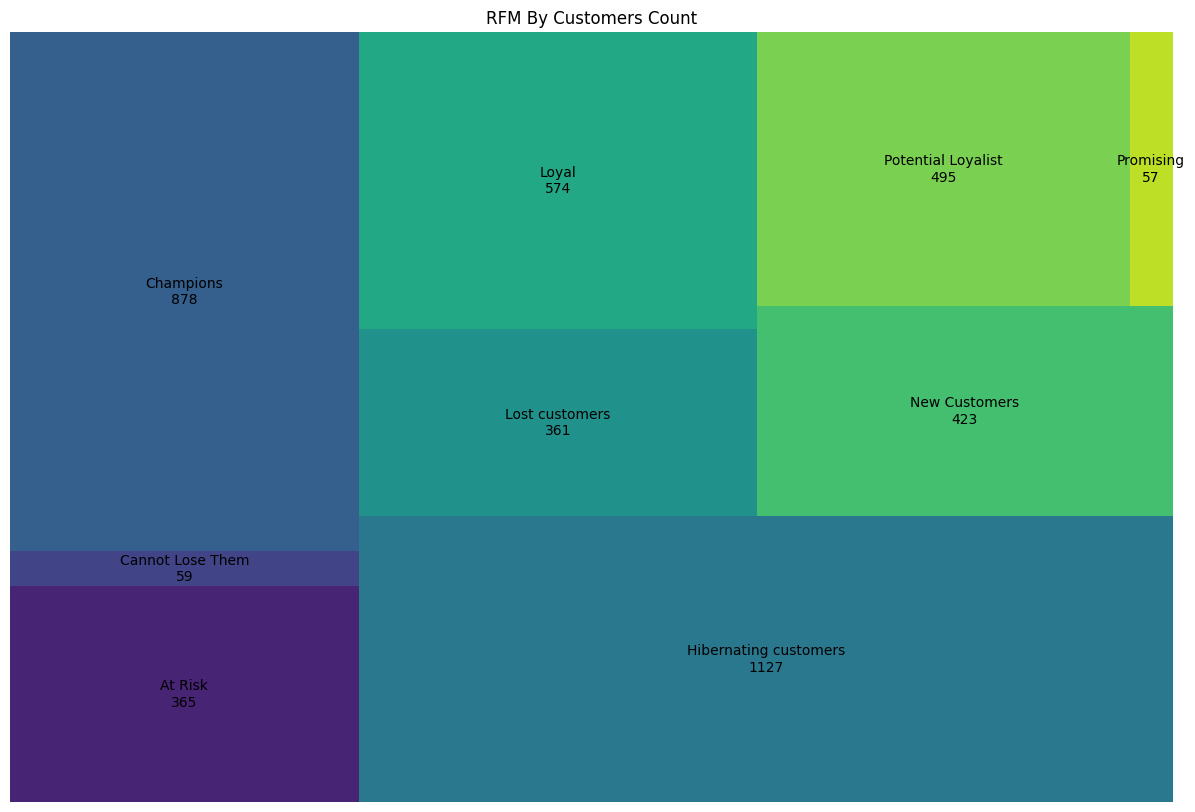

In [67]:
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))
squarify.plot(
    rfm_summarised['customersCount'].to_list(),
    label = rfm_summarised['Segment'] + '\n' + rfm_summarised['customersCount'].astype(str),
    color = sns.color_palette ('viridis', len( rfm_summarised['Segment'].to_list()))
)
plt.title ('RFM By Customers Count')
plt.axis("off")

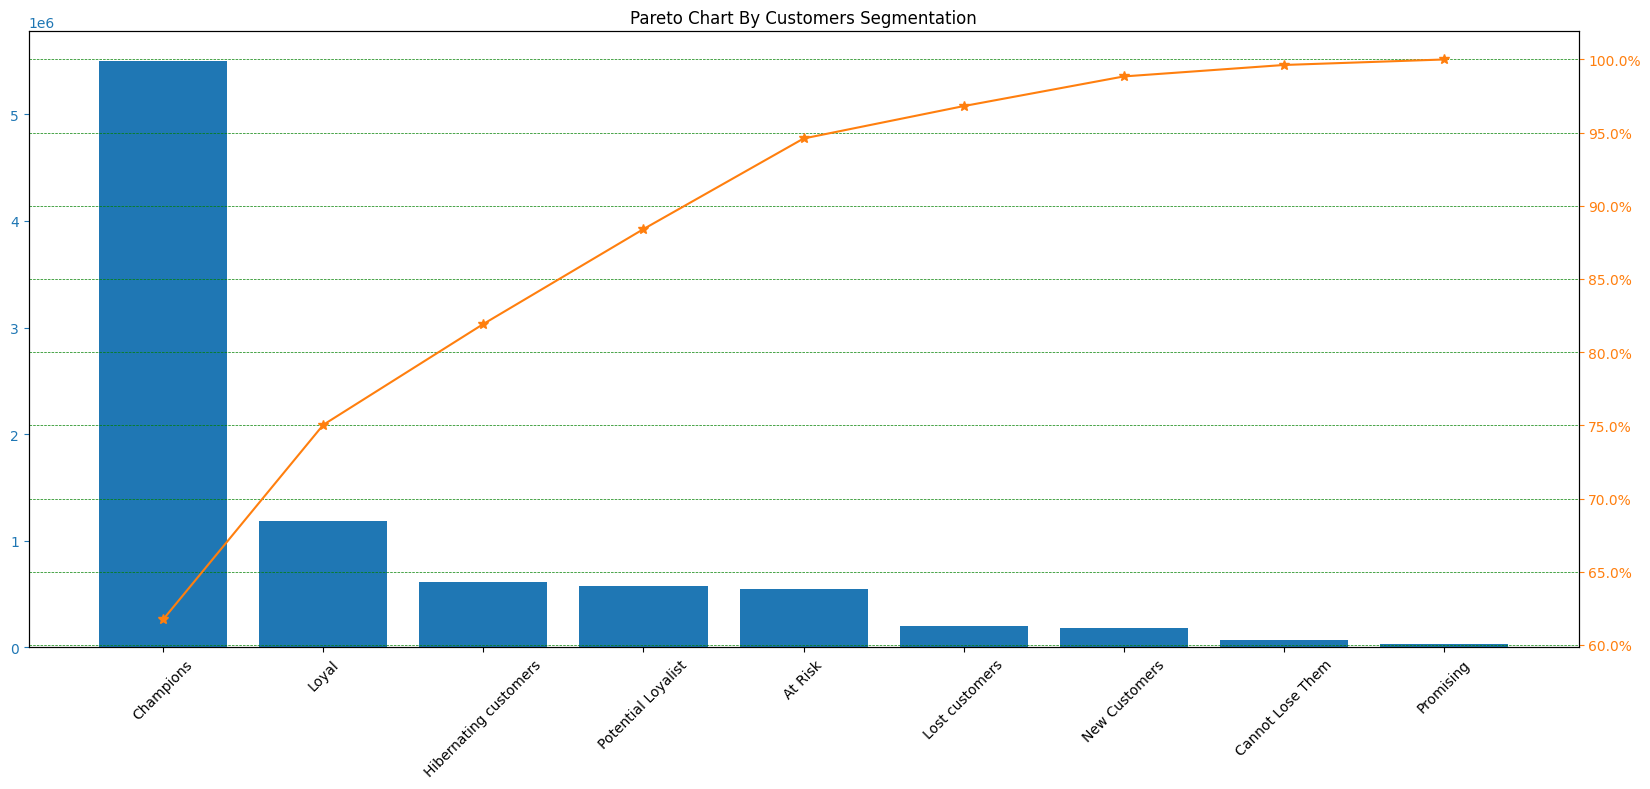

In [68]:
from matplotlib.ticker import PercentFormatter
rfm_summarised = rfm_summarised.sort_values(by='total_M',ascending=False)
rfm_summarised["cumpercentage"] = rfm_summarised["total_M"].cumsum()/rfm_summarised["total_M"].sum()*100
fig, ax = plt.subplots(figsize = (20, 8))
ax.bar(rfm_summarised['Segment'], rfm_summarised["total_M"], color="C0")
ax2 = ax.twinx()
ax2.plot(rfm_summarised['Segment'], rfm_summarised["cumpercentage"], color="C1", marker="*", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.title ('Pareto Chart By Customers Segmentation')
plt.show()

In [70]:
rfm_summarised["total_M_cumsum"] = rfm_summarised["total_M"].cumsum()
rfm_summarised["total_M_sum"] = rfm_summarised["total_M"].sum()

In [71]:
rfm_summarised.head()

,Segment,customersCount,total_R,total_F,total_M,cumpercentage,total_M_cumsum,total_M_sum
2,Champions,878,4356568,10302,5501923.730,61.740230,5501923.730,8911407.904
5,Loyal,574,2863836,2865,1184968.371,75.037437,6686892.101,8911407.904
3,Hibernating customers,1127,5749026,1606,614059.263,81.928147,7300951.364,8911407.904
7,Potential Loyalist,495,2465639,1156,577820.820,88.412205,7878772.184,8911407.904
0,At Risk,365,1865503,1405,551560.310,94.601578,8430332.494,8911407.904
